In [3]:
from __future__ import division
import numpy as np
import pandas as pd

import itertools
import collections
import seaborn as sns
import matplotlib.pylab as plt
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import plotly
plotly.tools.set_credentials_file(username='albe88', api_key='FuLM7dUFVugZfDaWxk6O')
% matplotlib inline

ImportError: C extension: DLL load failed: %1 non è un'applicazione di Win32 valida. not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext --inplace --force' to build the C extensions first.

## Data Preparation

In [4]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', re.sub('<\s*.*?>','',token)):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', re.sub('<\s*.*?>','',token)):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
df = pd.read_csv('interview_test.csv', header=None, names=['text'])

In [6]:
#Using set instead of lists as it there is duplicates in the dataset
all_documents = list({text for text in df.text})

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amministratore\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [9]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in all_documents:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print '{} items in vocab_frame'.format(str(vocab_frame.shape[0]))

557211 items in vocab_frame


In [11]:
#tokenize = lambda doc: doc.lower().split(" ")
sklearn_tfidf = TfidfVectorizer(norm='l2',stop_words=u'english', lowercase=True, min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True,ngram_range=(1,3), tokenizer=tokenize_and_stem)
sklearn_representation = sklearn_tfidf.fit_transform(all_documents)

In [ ]:
vocab = np.array(sklearn_tfidf.get_feature_names())
#results = np.array(sklearn_representation.toarray())
#sklearn_representation.toarray()


In [17]:
results = np.array(sklearn_representation.toarray())

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

##### Reuslts TF-IDF
Just looking at the first 10 documents to chek the most relevant word in each text, and double check if the *tokenization* worked well *(Used unigram, bigram and trigram)*.

In [13]:
for idx, i in enumerate(itertools.islice(results,10)):
    vec = np.argsort(i)
    print ('Document {}'.format(idx +1))
    print (zip(vocab[i.argsort()][::-1][0:4], np.round(i[i.argsort()][::-1][0:5],4)))
    

NameError: name 'results' is not defined

Cosine distance scikit learn

In [103]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(sklearn_representation)

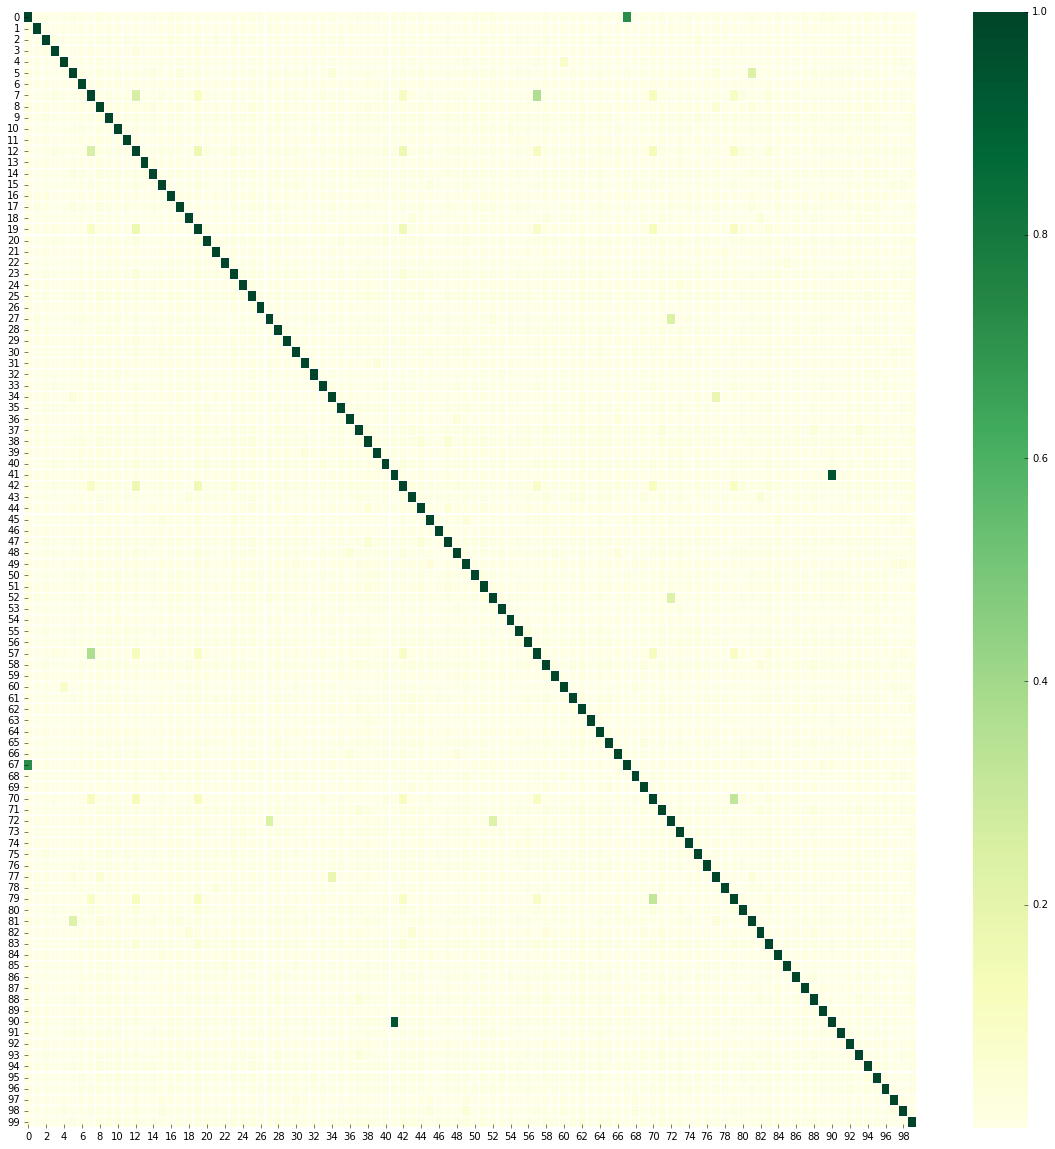

In [117]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(dist[:100,:100], linewidth = 0.02, linecolor='White', cmap='YlGn', fmt='.2pg', ax=ax )


#### Exploring the data

Havong a look at the data, in the heatmap documents at index 41 and 90 in the list look very similar between them. Looking at them, appart from the first two sentences, the text look equal. More work to be done for excluding duplicate (creating a list from a set is not enough for excluding duplicates).

In [124]:
print (all_documents[90])
print ('###############')
print (all_documents[41])

Regional freeads (within 50 miles of Bournemouth) AT 640 food processor attachment for Kenwood chef. New unused. With knife and disc attachments. Makes easy work of blending, chopping shredding etc. I bought this in error as it doesn't fit my kenwood chef. I believe it it for titanium and km020 , 23 , 30, models. This can be checked online against your chef model... This kenwood mixer was bought by my sister who sadly passed away 6 weeks after purchase. Hence why its nearly new and in excellent condition as it was only used twice. It has all attachments with it. It cost 319 new 24.99 I have got 2 pieces of BRAND NEW Blenders to sell EK2229. BEST PRICE GUARANTED! Make delicious smoothies for the whole family with this fantastic Salter Blender To Go featuring 350W power and one-touch blending. Compact and convenient, it comes with a 600ml capacity bottle with a flip lip and a 1 litre glass... 90 Brand new Original Nutri-bullet blender, complete with three different size blender pots and 

## Clustering

Using k-means to cluster vectors from **Tf-Idf** fit.

Trying to understand the optimal number of clusters, using **Elbow Analysis** (Variance explained as function of number of cluster)

In [63]:
from sklearn.cluster import KMeans

cluster_range = range(21)
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( n_clusters=num_clusters)
  clusters.fit(sklearn_representation) 
  cluster_errors.append( clusters.inertia_)

In [145]:
print (type(sklearn_representation))

<class 'scipy.sparse.csr.csr_matrix'>


In [57]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors })

Looking at the graph below, looks like the relation between the number of cluster and variance is alomst **linear**.

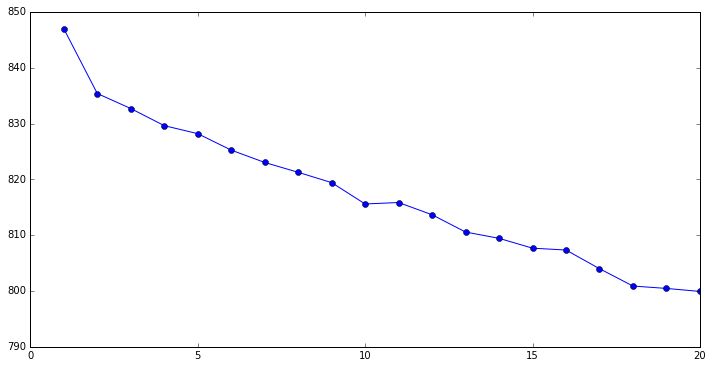

In [98]:
plt.figure(figsize=(12,6))
plt.plot(cluster_df.num_clusters, cluster_df.cluster_errors, marker = "o" )

In [ ]:

num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(sklearn_representation)

clusters = km.labels_.tolist()

In [45]:
from sklearn.externals import 

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [46]:
len(clusters)

856

In [47]:
films = { 'Text': all_documents, 'cluster': clusters}

frame = pd.DataFrame(films, index = [clusters] , columns = ['Text','cluster'])

In [48]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)


4    241
2    166
6     99
9     87
3     70
8     57
5     46
1     32
7     30
0     28
Name: cluster, dtype: int64

In [82]:
#from __future__ import print_function

def get_KM_results(km, num_clusters, number_of_words = 10):
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')

        for ind in order_centroids[i, : number_of_words]: #replace 6 with n words per cluster
            #print('{}'.format(str(vocab_frame.ix[vocab[ind].split(' ')].values.tolist()[0][0]).encode('utf-8', 'ignore'), end=','))
            print(' %s' % str(vocab_frame.ix[vocab[ind].split(' ')].values.tolist()[0][0]).encode('utf-8', 'ignore'), end=',')
        print() #add whitespace
        print() #add whitespace
    print()
    print()

In [83]:
get_KM_results(km,10)

Top terms per cluster:

Cluster 0 words: workout, exercise, routine, burning, cardio, fit, muscles, body, calories, hiit,

Cluster 1 words: 3d, artist, popular, 's, popular, 3d, 3d, programs, modeled, better,

Cluster 2 words: blender, blending, smoothies, n't, used, 's, make, soups, food, kitchen,

Cluster 3 words: coffee, beans, coffee, jar, reviewed, margaritas, smoothies, blender, grind, grind,

Cluster 4 words: blender, used, creating, make, product, 3d, like, modeled, blending, nutribullet,

Cluster 5 words: recipe, blender, make, smoothies, used, love, just, juice, share, recipe,

Cluster 6 words: muffins, recipe, chocolate, im, bake, love, banana, butters, batter, make,

Cluster 7 words: video, free, video, step-by-step, including, including, information, step-by-step, step-by-step, tricks,

Cluster 8 words: kenwood, steel, blender, motor, stainless, stainless, blades, litre, steel, attaching,

Cluster 9 words: hand, attaching, blender, hand, whisking, blending, chopper, immers

In [148]:
km.cluster_centers_.argsort()[:, ::-1][0].shape

(412068,)

In [138]:
df_clust = frame.loc[4]

In [143]:
df_clust

,Text,cluster
4,How to Animate a dragon in flight with Blender...,4
4,4-Year Extended Warranty (recommended) $19.99 ...,4
4,"Sponge applicators, like our beloved beautyble...",4
4,How I learned Blender and 5 Tips for You I us...,4
4,How to Make Your Dirty Blender Clean Itself Cl...,4
4,Battle of the blenders: are the Nutribullet's ...,4
4,Please note: If you live outside of North Amer...,4
4,Wave~Action system provides super-smooth drink...,4
4,TAMPA A Florida couple is suing a blender man...,4
4,Blender is an integrated application that enab...,4
